# Homework 5 - USA Airport Flight Analysis

Let's import all the libraries that we will need for this homework.

In [2]:
# Importing libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import plotly.express as px
import plotly.graph_objs as go
import dask.dataframe as dd
import folium
from folium import FeatureGroup, LayerControl
import seaborn as sns
import functions
from collections import defaultdict
import heapq

In [3]:
from importlib import reload
reload(functions)

<module 'functions' from 'c:\\Users\\matti\\Documents\\ADM\\HW5\\ADM_HW05\\functions.py'>

# Data Analysis

In [3]:
# Download Dataset
data = pd.read_csv(r"Airports2.csv")

Some information about our dataset.

In [4]:
# Viewing the data
data.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [5]:
# Describing the data
data.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [6]:
# Data types
data.dtypes

Origin_airport             object
Destination_airport        object
Origin_city                object
Destination_city           object
Passengers                  int64
Seats                       int64
Flights                     int64
Distance                    int64
Fly_date                   object
Origin_population           int64
Destination_population      int64
Org_airport_lat           float64
Org_airport_long          float64
Dest_airport_lat          float64
Dest_airport_long         float64
dtype: object

## Missing Values

In [7]:
# Checking for missing values
missing_values = data.isna().sum()
print(missing_values)

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


As we can see there are a lot of missing values when it comes to the coordinates of the airports. So we have to fill them.

In [8]:
unique_airports = pd.concat([data['Origin_airport'], data['Destination_airport']]).unique()
print(f"Unique airports to process: {len(unique_airports)}")

Unique airports to process: 727


We are going to use the <strong> geopy </strong> library in order to find the coordainates of the airports 

In [9]:
# Initialize the geolocator
geolocator = Nominatim(user_agent="flight_network_analysis", timeout=10)

# Define a function to fetch coordinates
def fetch_coordinates(airport_code, retries=3):
    """
    Fetches the latitude and longitude for a given airport code.
    Retries in case of timeout.
    """
    for attempt in range(retries):
        try:
            location = geolocator.geocode(f"{airport_code} airport")
            if location:
                return location.latitude, location.longitude
        except GeocoderTimedOut:
            print(f"Retrying for {airport_code}... (Attempt {attempt + 1})")
            time.sleep(1)  # Delay before retry
    return None, None  # If all retries fail

In [10]:
# Create a DataFrame to store airport coordinates
airport_coordinates = pd.DataFrame(unique_airports, columns=['Airport'])
airport_coordinates['Latitude'] = None
airport_coordinates['Longitude'] = None

In [11]:
# Fetch coordinates for all unique airports
for idx, airport in airport_coordinates.iterrows():
    lat, long = fetch_coordinates(airport['Airport'])
    airport_coordinates.at[idx, 'Latitude'] = lat
    airport_coordinates.at[idx, 'Longitude'] = long

In [12]:
# Create mapping dictionaries
lat_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Latitude']))
long_mapping = dict(zip(airport_coordinates['Airport'], airport_coordinates['Longitude']))

In [13]:
# Fill missing values
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(data['Origin_airport'].map(lat_mapping))
data['Org_airport_long'] = data['Org_airport_long'].fillna(data['Origin_airport'].map(long_mapping))
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(data['Destination_airport'].map(lat_mapping))
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(data['Destination_airport'].map(long_mapping))

After this process we will check again for missing values.

In [14]:
# Checking for any other missing values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      1163
Org_airport_long     1163
Dest_airport_lat     1147
Dest_airport_long    1147
dtype: int64


As we can see the missing values have decreased but we still have some. For these airports, we will create a manual dictionary which will have the lat and the long for each airport of the missing values.

In [15]:
# Identify missing origin airport codes
missing_origin_airports = data.loc[data['Org_airport_lat'].isna(), 'Origin_airport'].unique()
print(f"Missing Origin Airports: {missing_origin_airports}")

# Identify missing destination airport codes
missing_dest_airports = data.loc[data['Dest_airport_lat'].isna(), 'Destination_airport'].unique()
print(f"Missing Destination Airports: {missing_dest_airports}")

Missing Origin Airports: ['DQF' 'KY5' 'HIK' 'ESF' 'VWL' 'XXW' 'FVS' 'HLM' 'JSE' 'TN6' 'AIY' 'JRA'
 'JRB' 'TSS' 'WQM' 'KY1' 'IN1' 'TN3' 'OH5' 'KY3' 'OH3' 'VWT' 'WV1' 'OH2'
 'VWH' 'MI2' 'VWD' 'NY3' 'LSD' 'DQU' 'LWF' 'JZU' 'STF' 'TX6' 'OH1' 'DQC'
 'CGX']
Missing Destination Airports: ['IN1' 'TX6' 'JSE' 'AWX' 'VWL' 'CGX' 'VWD' 'HLM' 'MI2' 'LJY' 'VWH' 'NY3'
 'DQF' 'FVS' 'KY1' 'HIK' 'TSS' 'JRA' 'JRB' 'UXJ' 'XWL' 'TN6' 'ZXX' 'DQU'
 'XXW' 'TN3' 'LSD' 'NZJ' 'ESF' 'WV1' 'OH5' 'STF' 'OH3' 'WQM' 'LWF' 'KY5'
 'AIY' 'JCC' 'KY3' 'OH1']


In [16]:
# Creating the dictionary
manual_airport_coordinates = {
    'DQF' : (32.897480, -97.040443),  
    'KY5' : (37.5355556, -84.4072222),
    'HIK' : (21.32583333, -157.92166666),
    'ESF' : (31.395, -92.29583),
    'VWL' : (47.37611111, -94.79805555),
    'XXW' : (30.18055555, -82.57972222),
    'FVS' : (43.83388888,  -111.805),
    'HLM' : (42.79583, -86.16194),
    'JSE' : (58.30166666, -134.42444444),
    'TN6' : (35.99861111, -89.40611111),
    'AIY' : (39.3577777778, -74.46),
    'JRA' : (40.754626, -74.006808),
    'JRB' : (40.701116, -74.008801),
    'TSS' : (40.7425, -73.97194),
    'WQM' : (30.2125, -93.14333333),
    'KY1' : (37.56861111, -84.77222222),
    'IN1' : (41.30694444, -85.06416666),
    'TN3' : (35.50694444, -86.80361111),
    'OH5' : (39.24666666, -84.38888888),
    'KY3' : (38.058056, -83.979444),
    'OH3' : (39.44027777, -83.02305555),
    'VWT' : (32.11166666, -84.18833333),
    'WV1' : (38.29444444, -81.56555555),
    'OH2' : (40.3722222222, -83.8188888889),
    'VWH' : (31.9208333333, -102.3894444444),
    'MI2' : (42.74305555, -86.105),
    'VWD' : (36.31888888, -119.62972222),
    'NY3' : (42.45, -75.01638888),
    'LSD' : (38.09111111, -84.31666666),
    'DQU' : (55.77888888, -131.60138888),
    'LWF' : (35.23416666, -87.25805555),
    'JZU' : (42.89138888, -73.24638888),
    'STF' : (33.433056, -88.848611),
    'TX6' : (35.22202, -101.831642),
    'OH1' : (39.57027777, -83.42055555),
    'DQC' : (27.81277777, -80.49555555),
    'CGX' : (41.86, -87.6086111111),
    'AWX' : (32.32944444, -102.53027777),
    'UXJ' : (37.63138888, -84.33249999),
    'XWL' : (43.2125, -112.34583333),
    'ZXX' : (46.21833333, -119.20944444),
    'NZJ' : (33.67611, -117.73111),
    'JCC' : (37.8, -122.46666666),
    'LJY' : (37.64444444, -92.6525),
}

In [17]:
# Fill missing origin coordinates 
data['Org_airport_lat'] = data['Org_airport_lat'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Org_airport_long'] = data['Org_airport_long'].fillna(
    data['Origin_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

# Fill missing destination coordinates  
data['Dest_airport_lat'] = data['Dest_airport_lat'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[0])
)
data['Dest_airport_long'] = data['Dest_airport_long'].fillna(
    data['Destination_airport'].map(lambda x: manual_airport_coordinates.get(x, (None, None))[1])
)

Checking one more time for any missing values after applying the dictionary.

In [18]:
# Checking for any other missinf values
print(data[['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long']].isna().sum())

Org_airport_lat      0
Org_airport_long     0
Dest_airport_lat     0
Dest_airport_long    0
dtype: int64


In [19]:
# Save the dataset as a CSV, given the cleaning time is not very short, so I can reload it without having to reprocess it.
data.to_csv("AirportsClean.csv")
#data = pd.read_csv(r"AirportsClean.csv")

## Visualizing Data

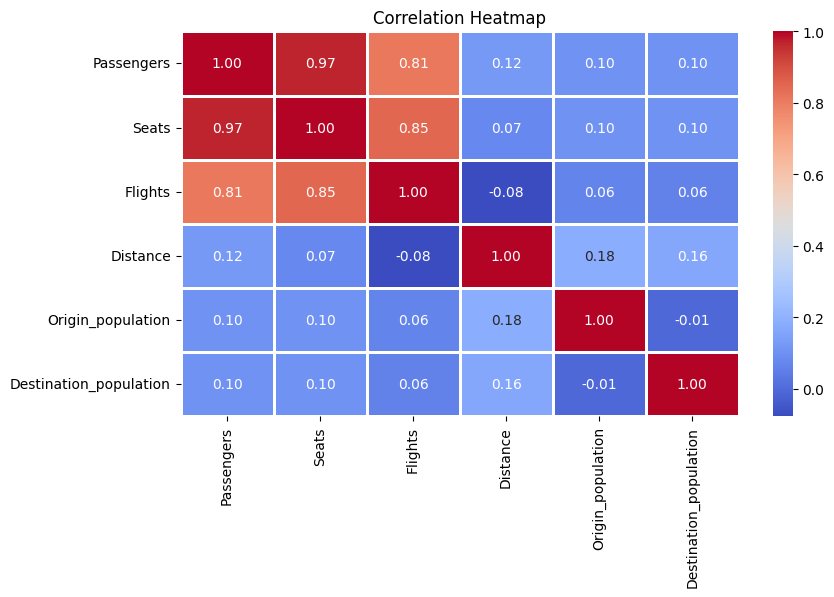

In [20]:
# Correlation Heatmap
numerical_columns = ['Passengers', 'Seats', 'Flights', 'Distance', 'Origin_population', 'Destination_population']
corr_matrix = data[numerical_columns].corr()

plt.figure(figsize=(9, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

# 1. Flight Network Analysis (Q1)

Before make the graph we have to find out if the graph is directed or undirected. So we are going to analyze how many routes are reciprocal (have both directions) and calculate the percentage. Let's set the threshold at 70%. So if reciprocity is >= 70% we will treat our graph as undirected. If not, we will treat our graph as directed.

In [5]:
# Group data to ensure unique routes
unique_routes = data[['Origin_airport', 'Destination_airport']].drop_duplicates()

# Create a set of routes and reverse routes
routes = set(tuple(x) for x in unique_routes.to_numpy())
reverse_routes = set((dest, origin) for origin, dest in routes)

# Count reciprocal routes
reciprocal_routes = routes.intersection(reverse_routes)
reciprocity = len(reciprocal_routes) / len(routes) if len(routes) > 0 else 0

print(f"Total Routes: {len(routes)}")
print(f"Reciprocal Routes: {len(reciprocal_routes)}")
print(f"Reciprocity: {reciprocity:.2%}")

Total Routes: 36719
Reciprocal Routes: 27188
Reciprocity: 74.04%


As we can see the reciprocity is 74.04%, so our graph will be a undirected one.

In [6]:
# Create graph
flight_network = nx.Graph()
    
# Add edges
for _, row in data.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    flight_network.add_edge(origin, destination)

## 1.2 Implement a function <strong> analyze_graph_features(flight_network) </strong>

Number of airports (nodes): 727
Number of flights (edges): 23260
Graph density: 0.0881


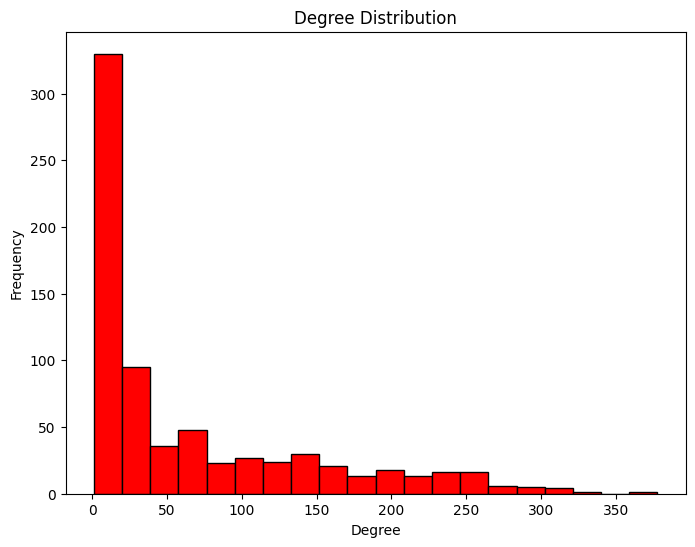

Hubs (airports with degree > 90th percentile): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'HSV', 'MIA', 'TPA', 'DAL', 'JAX']
The graph is sparse.


In [7]:
functions.analyze_graph_features(flight_network)

## 1.2 Write a function <strong> summarize_graph_features(flight_network) </strong>

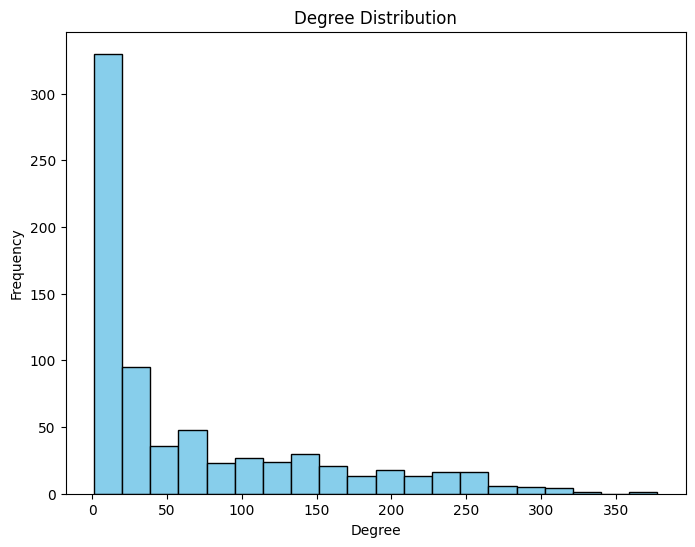


--- Graph Summary Report ---
Number of nodes: 727
Number of edges: 23260
Graph density: 0.08813911277335061

Hubs:
Airport  Degree
    YIP     378
    MSP     323
    MCI     319
    MEM     317
    ATL     308
    STL     304
    ORD     299
    MIA     299
    DFW     297
    IND     296
    OKC     290
    PHX     281
    SHV     280
    IAD     276
    DTW     272
    SLC     266
    LAS     266
    IAH     264
    MKE     264
    BWI     263
    LAX     262
    CLE     260
    ELP     259
    TUS     255
    JFK     255
    LIT     254
    EWR     252
    BNA     252
    CVG     252
    MDW     251
    PHL     250
    PIT     248
    RFD     247
    BOS     244
    CLT     244
    LRD     244
    ICT     243
    SAT     243
    MCO     241
    DAY     240
    RDU     239
    CMH     238
    SEA     235
    MSY     234
    DAL     234
    TUL     233
    TYS     230
    SFO     230
    OMA     229
    FLL     226
    BUF     225
    ABQ     223
    AUS     220
    OAK     219
    

{'Number of nodes': 727,
 'Number of edges': 23260,
 'Graph density': 0.08813911277335061,
 'Hubs':    Airport  Degree
 55     YIP     378
 29     MSP     323
 27     MCI     319
 33     MEM     317
 46     ATL     308
 ..     ...     ...
 42     HOU     200
 56     LGA     199
 49     GSO     198
 72     JAX     198
 68     HSV     197
 
 [73 rows x 2 columns]}

In [8]:
functions.summarize_graph_features(flight_network)

## 1.3 Deeper analysis of the dataset

Compute total passenger flow between origin and destination cities.

In [9]:
# Compute total passengers for each route
passenger_flow = data.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()
passenger_flow = passenger_flow.rename(columns={'Passengers': 'Total_Passengers'})
passenger_flow

,Origin_airport,Destination_airport,Total_Passengers
0,1B1,BDL,1
1,ABE,ABE,2524
2,ABE,ACT,0
3,ABE,ACY,73
4,ABE,ADS,0
...,...,...,...
36714,YUM,YUM,0
36715,ZZV,MCI,0
36716,ZZV,PDK,0
36717,ZZV,SHV,0


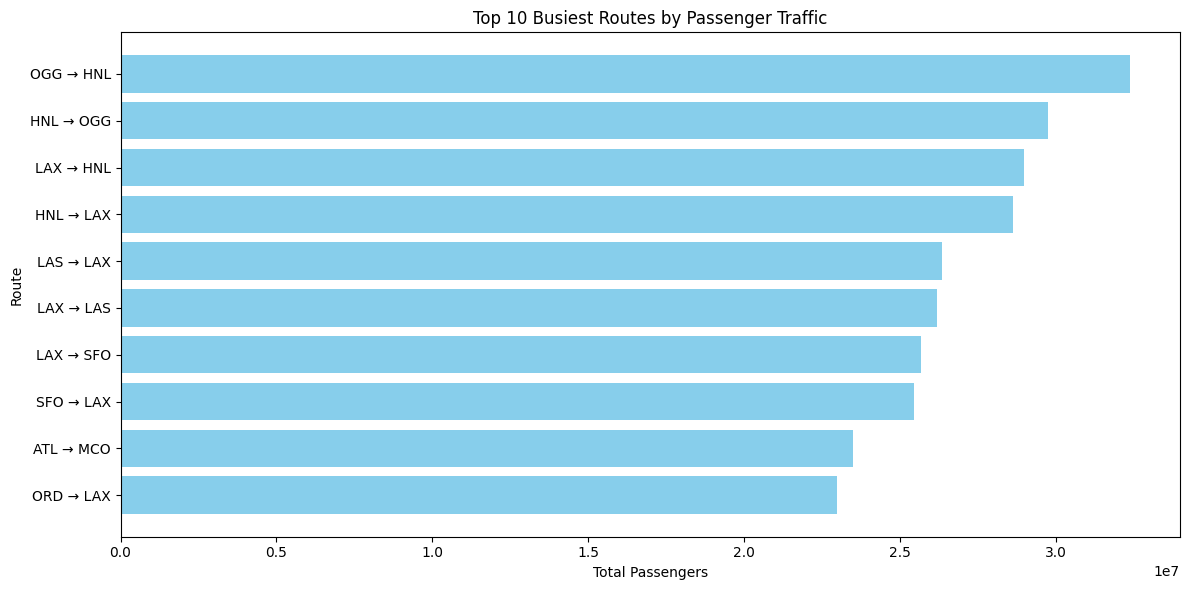


Top 10 Busiest Routes (Table):
Origin_airport Destination_airport  Total_Passengers
           OGG                 HNL          32364612
           HNL                 OGG          29744742
           LAX                 HNL          28964154
           HNL                 LAX          28632161
           LAS                 LAX          26333721
           LAX                 LAS          26177809
           LAX                 SFO          25661782
           SFO                 LAX          25458207
           ATL                 MCO          23483751
           ORD                 LAX          22979359


In [10]:
# Identify top 10 busiest routes
busiest_routes = passenger_flow.sort_values(by='Total_Passengers', ascending=False).head(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(
    busiest_routes.apply(lambda x: f"{x['Origin_airport']} → {x['Destination_airport']}", axis=1),
    busiest_routes['Total_Passengers'],
    color='skyblue'
)
plt.xlabel('Total Passengers')
plt.ylabel('Route')
plt.title('Top 10 Busiest Routes by Passenger Traffic')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the table of top 10 busiest routes
print("\nTop 10 Busiest Routes (Table):")
print(busiest_routes.to_string(index=False))  

In [11]:
# Compute average passengers per flight
data['Avg_Passengers_Per_Flight'] = data['Passengers'] / data['Flights']

# Compute seat utilization for each route
data['Seat_Utilization'] = (data['Passengers'] / data['Seats']) * 100

# Classify routes as under-utilized or over-utilized
data['Utilization_Class'] = data['Seat_Utilization'].apply(
    lambda x: 'Under-utilized' if x < 70 else 'Over-utilized'
)
utilization_analysis = data[['Origin_airport', 'Destination_airport', 'Avg_Passengers_Per_Flight', 'Seat_Utilization', 'Utilization_Class']]
utilization_analysis

,Origin_airport,Destination_airport,Avg_Passengers_Per_Flight,Seat_Utilization,Utilization_Class
0,MHK,AMW,21.000000,70.000000,Over-utilized
1,EUG,RDM,1.863636,10.353535,Under-utilized
2,EUG,RDM,4.631579,25.730994,Under-utilized
3,EUG,RDM,2.750000,15.277778,Under-utilized
4,MFR,RDM,0.000000,0.000000,Under-utilized
...,...,...,...,...,...
3606798,STL,TBN,5.509804,28.998968,Under-utilized
3606799,STL,TBN,4.537037,23.879142,Under-utilized
3606800,STL,TBN,5.417910,28.515318,Under-utilized
3606801,CGI,TBN,2.000000,10.526316,Under-utilized


Top routes by passenger efficiency (table and bar chart).

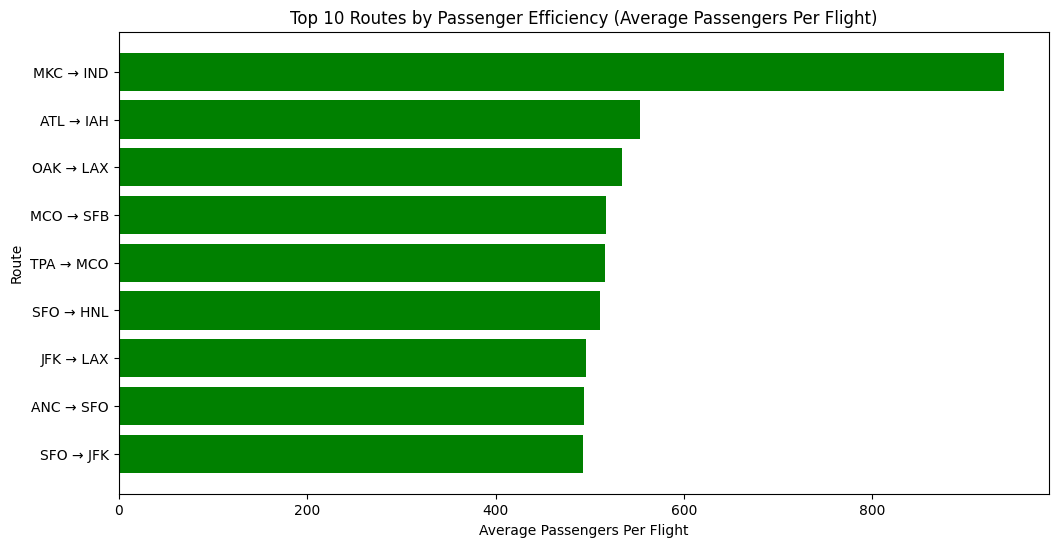

Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight):


,Origin_airport,Destination_airport,Passengers,Flights,Passenger_Efficiency
3256852,MKC,IND,940,1,940.000000
1040966,ATL,IAH,553,1,553.000000
2989778,OAK,LAX,534,1,534.000000
1340834,MCO,SFB,517,1,517.000000
1341272,TPA,MCO,516,1,516.000000
1639561,SFO,HNL,6644,13,511.076923
2977661,JFK,LAX,496,1,496.000000
3426967,ANC,SFO,494,1,494.000000
3426707,ANC,SFO,494,1,494.000000
1701095,SFO,JFK,493,1,493.000000


In [12]:
# Compute average passengers per flight
data['Passenger_Efficiency'] = np.where(
    data['Flights'] == 0, 
    0,  # Assign 0 efficiency if no flights
    data['Passengers'] / data['Flights']
)
    
# Sort by Passenger Efficiency and get top 10 routes
top_routes = data.sort_values(by='Passenger_Efficiency', ascending=False).head(10)
    
# Bar Chart for Passenger Efficiency
plt.figure(figsize=(12, 6))
plt.barh(
    top_routes.apply(
        lambda x: f"{x['Origin_airport']} → {x['Destination_airport']}", axis=1
    ),
    top_routes['Passenger_Efficiency'],
    color='green'
)
plt.xlabel('Average Passengers Per Flight')
plt.ylabel('Route')
plt.title('Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight)')
plt.gca().invert_yaxis()
plt.show()
    
# Display the table
print("Top 10 Routes by Passenger Efficiency (Average Passengers Per Flight):")
display(top_routes[['Origin_airport', 'Destination_airport', 'Passengers', 'Flights', 'Passenger_Efficiency']])

Create an interactive map visualizing the geographic spread of the flight network.

In [13]:
# Read large CSV using Dask
ddf = dd.read_csv(r"Airports2.csv")
    
# Aggregate routes
route_aggregation = ddf.groupby([
    'Origin_airport', 
    'Destination_airport', 
    'Origin_city', 
    'Destination_city',
    'Org_airport_lat', 
    'Org_airport_long', 
    'Dest_airport_lat', 
    'Dest_airport_long'
    ])['Passengers'].sum().reset_index()
    
# Compute the aggregation
route_data = route_aggregation.compute()    

In [ ]:
 # Create interactive map
functions.create_flight_network_map(route_data)

### Due to the heaviness of the interactive map, this cell displays a screenshot of the result of the above function 'functions.create_flight_network_map(route_data)'; to interact with the map, you can run the notebook via the Google Colab link provided in the README file.

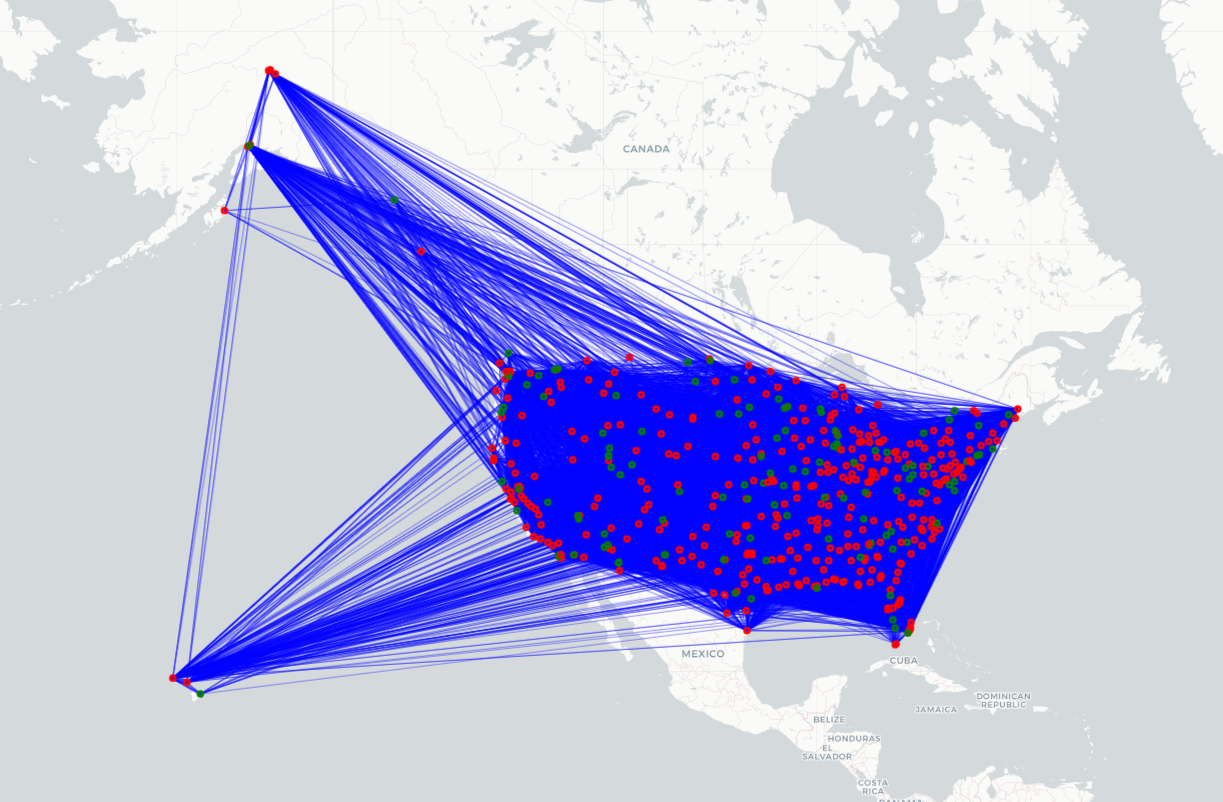

## Final Questions

<strong> 1. Is the graph sparse or dense? </strong>

The graph is sparse with 0.088 density.

<strong> 2. What patterns do you observe in the degree distribution? </strong>

As we can see from the plots most of the airports have a low degree which means that their connections are few. When it comes to high degree airports, there aren't many but their degree is very high making them super important nodes of the graph.

<strong> 3. Which airports are identified as hubs, and why? </strong>

Some airports that have identify as hubs are:

- YIP (degree: 378)
- MSP (degree: 323)
- MCI (degree: 319)
- MEM (degree: 317)
- ATL (degree: 308)

They are hubs because they are airports with degree > 90th percentile.

<strong> 4. What are the busiest routes in terms of passenger traffic? </strong>

The top 3 busiest routes in terms of passenger traffic are:

- OGG  ->  HNL, with total passengers: 32364612
- HNL  ->  OGG, with total passengers: 29744742
- LAX  ->  HNL, with total passengers: 28964154

<strong> 5. Which routes are under/over-utilized? </strong>

Under-utilized routes are routes with low passenger traffic(calculated by the the percentage of seats filled on the flight) and low average passengers per flight.

Over-utilized routes are routes with high passenger traffic and high average passengers per flight.

# 2. Nodes' Contribution (Q2)

In any network, certain nodes (airports) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.

In [37]:
df = pd.read_csv(r"AirportsClean.csv")

We don't need the entire dataset, so we create a DataFrame composed only of the columns Origin_airport, Destination_airport and Distance.
We notice that sometimes, for the same Origin_airport and Destination_airport pair, there are different distance values (likely due to measurement errors or changes in territories over time). 
To resolve this, we replace the distance value with the most frequent distance value (the mode) for each Origin_airport and Destination_airport pair using the function `build_df_for_network

In [38]:
# Save the resulting DataFrame from `build_df_for_network` in the variable `df_util`
df_util = functions.build_df_for_network(df)

# Construction of the directed graph with distances (for centrality measures, the distance will be used as the weight of the edges)
flight_network = functions.build_graph(df_util)

df_util.head()

,Origin_airport,Destination_airport,Distance
0,MHK,AMW,254
1,EUG,RDM,103
4,MFR,RDM,156
9,SEA,RDM,228
14,PDX,RDM,116


### Implement function `analyze_centrality(flight_network, airport)`

This function takes a graph and a node within it and returns the value of four centrality measures for that node:
- Betweenness centrality
- Closeness centrality
- Degree centrality
- PageRank

In our context, the graph represents flights from one airport to another, and the weights of the graph correspond to the distances between airports. 
The directed graph object is created using the function `build_graph`, which leverages the method `DiGraph` from the library **NetworkX**, starting from the previously cleaned dataset `df_util`.
For the calculation of each centrality measure, a separate function has been implemented, which will then be called by `analyze_centrality`.



In [39]:
input_airport = "YIP"
functions.analyze_centrality(flight_network, input_airport )

{'Betweenness Centrality': 0.32333452216274433,
 'Closeness Centrality': 0.00108300373460128,
 'Degree Centrality': 665,
 'PageRank': 0.011968947291634198}

### Implement function `compare_centralities(flight_network)`


This function: 

- Takes as input the same graph representing flights that we have been using so far.
- Calls the four implemented functions to calculate the respective centralities.
- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.


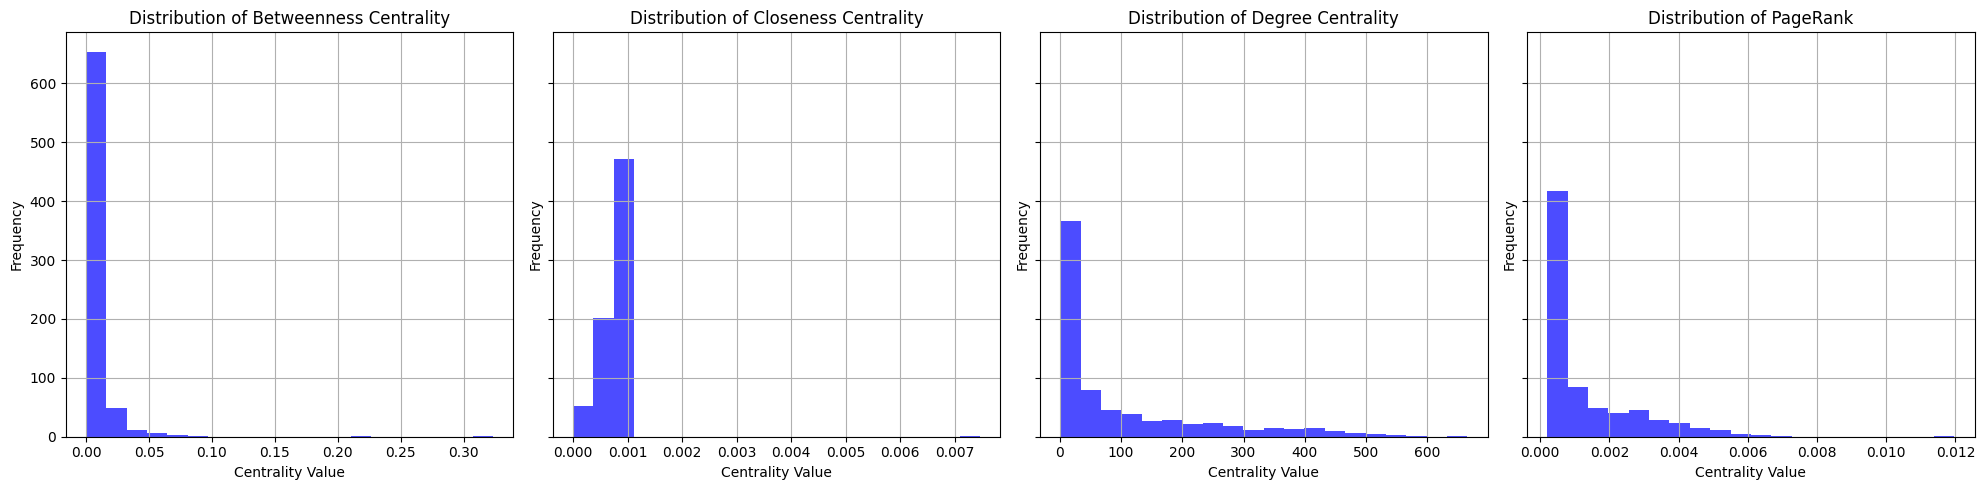

Top 5 airports for Betweenness Centrality: {'YIP': 0.32333452216274433, 'WFB': 0.3079985170796882, 'KTN': 0.21905510499998557, 'MTN': 0.0924843273053154, 'ATL': 0.07932240326645668}
Top 5 airports for Closeness Centrality: {'FVS': 0.007462686567164179, 'STL': 0.0010968246383736588, 'CMI': 0.0010956331194240101, 'DEC': 0.0010939293881731843, 'SPI': 0.001093278117891566}
Top 5 airports for Degree Centrality: {'YIP': 665, 'MSP': 583, 'MEM': 564, 'ATL': 539, 'MCI': 539}
Top 5 airports for PageRank: {'YIP': 0.011968947291634198, 'SHV': 0.007198937602747061, 'MSP': 0.007116248610591993, 'MEM': 0.006639978857497354, 'MCI': 0.006622748106211989}


In [40]:
top_airports = functions.compare_centralities(flight_network)
for centrality, airports in top_airports.items():
    print(f"Top 5 airports for {centrality}: {airports}")


## Interpretation of the Centrality Istogram

**Distribution of Betweenness Centrality**
  - Most nodes have a very low Betweenness Centrality value, close to 0.
  - Only a few nodes stand out with higher values, suggesting they are crucial for transit along the shortest paths in the network.
  - This pattern is typical of networks where only a few nodes act as critical hubs connecting different parts of the graph.

**Distribution of Closeness Centrality**
  - The distribution is strongly concentrated around very low values, with little variation among nodes.
  - This suggests that most airports are not "close" in terms of geodesic distance to others.
  - This indicates a small subset of well-positioned nodes in the network.

**Distribution of Degree Centrality**
  - The distribution shows a long tail, with most nodes having a low or moderate number of connections.
  - Only a few nodes have a significantly high number of connections.
  - This reflects a hierarchical structure typical of transport networks, with certain airports serving as key hubs.

**Distribution of PageRank**
  - Most nodes have PageRank values close to 0, while a minority have higher values.
  - The long tail suggests that only a few nodes are particularly influential in the network.
  - PageRank considers not just the number of connections but also their quality, which explains why some less connected airports can have high values.

---

## We Asked ChatGPT for Alternative Centrality Measures

ChatGPT suggested Eigenvector Centrality.

### What is Eigenvector Centrality?
Eigenvector Centrality measures the influence of a node in a network, considering not only the number of connections that node has but also the importance of the nodes it is connected to. In other words, a node is considered highly central if it is connected to many other central nodes.

### Why Could It Be Useful?
- **Hierarchical Importance:** It can help identify airports that not only have many connections but are also connected to other key airports in the network.
- **Transport Networks:** In airline transport networks, airports with high Eigenvector Centrality are often hubs or key nodes with high strategic importance.
- **Global Value:** Unlike other measures such as Degree Centrality, which counts only direct connections, this measure also considers the "weight" of neighboring nodes.


In [41]:
# Calculate Eigenvector Centrality using the NetworkX library, which we are already familiar with, so we can rely on it.
eigenvector_centrality = nx.eigenvector_centrality(flight_network, max_iter=100, tol=1e-6)
print(eigenvector_centrality)

{'MHK': 0.0433824135092604, 'AMW': 0.00032313986225523337, 'EUG': 0.03234107479521774, 'RDM': 0.01726538183634629, 'MFR': 0.019632827404545278, 'SEA': 0.07459341615275006, 'PDX': 0.0636019273127726, 'LMT': 0.0076188171813636315, 'SFO': 0.07015483383125637, 'LAX': 0.0838760849705984, 'EAT': 0.004011774817744721, 'YKM': 0.028004656601007656, 'EKO': 0.0578524891433649, 'SLE': 0.0037523930736894054, 'GEG': 0.05361650563242531, 'RDD': 0.01747665283986343, 'LWS': 0.022665366868510083, 'AST': 0.0014772303697703137, 'CLM': 0.0028431860778987458, 'PDT': 0.005066411771671053, 'SJC': 0.06525301421399266, 'ACV': 0.006918755502846352, 'PUW': 0.020500364016935436, 'SMF': 0.05325163128178413, 'FLL': 0.08359797844488895, 'PHX': 0.0893796948717969, 'BFI': 0.060122372323164856, 'GGG': 0.055420339515806744, 'GTF': 0.03912099745592324, 'FAT': 0.04740289762527906, 'TUS': 0.08276856233401954, 'MWH': 0.02296608531993188, 'BIL': 0.04767586290890842, 'DFW': 0.09850258545524858, 'RBG': 0.0010462856787560317, 'S

## To Verify the Correctness of the Results

- We can compare the results with the graph's topology:  
  - **Isolated nodes or nodes with few connections:** These should have a low or zero centrality value.  
  - **Hub or highly connected nodes:** These should have higher centrality values.  
  By doing this, we observe that this is indeed the case.

- Finally, we can also compare Eigenvector Centrality with other measures, such as **Degree Centrality;** nodes with high Eigenvector Centrality values should generally have high Degree Centrality values, though not always, as Eigenvector Centrality considers the importance of neighbors.  




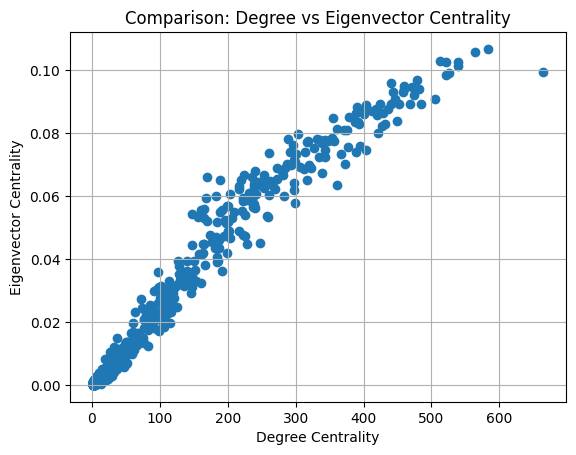

In [42]:
# Visual Comparison Between Degree Centrality and Eigenvector Centrality
degree_centrality_df = functions.calculate_degree_centrality(flight_network)  # DataFrame
degree_centrality = degree_centrality_df.set_index('Airport')['Total_degree']  # Extract Total_degree values

# Scatter plot
plt.scatter(degree_centrality.values, list(eigenvector_centrality.values()))
plt.title("Comparison: Degree vs Eigenvector Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Eigenvector Centrality")
plt.grid(True)
plt.show()


### **Positive Linear Relationship**  
The graph shows an upward pattern (a cluster of points diagonally from the bottom left to the top right):  
- This means that nodes with a high number of connections (high Degree Centrality) also tend to have a high Eigenvector Centrality.  
- This typically occurs in graphs where the main hubs are interconnected (as in our case with airline networks featuring many flights between major hubs).  

### Now we can compare this new centrality measure with the four previously calculated.  
To do so, we will use the output of the `compare_centralities` function. Let’s see what comes out!

In [70]:
# Compare the results of the Eigenvector Centrality measure with the four previously calculated measures, 
# whose results were saved in the 'top_airports' dictionary 
# (for practicality, this comparison will be made for the top 5 airports with the highest values).

# Get the top 5 airports for Eigenvector Centrality
top_5_eigenvector = dict(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# Add the new centrality to the dictionary
top_airports['Eigenvector Centrality'] = top_5_eigenvector

# Print all centralities with the top 5 airports
for centrality, top_5 in top_airports.items():
    print(f"Top 5 airports for {centrality}:")
    for airport, value in top_5.items():
        print(f"  {airport}: {value}")
    print()

Top 5 airports for Betweenness Centrality:
  YIP: 0.32333452216274433
  WFB: 0.3079985170796882
  KTN: 0.21905510499998557
  MTN: 0.0924843273053154
  ATL: 0.07932240326645668

Top 5 airports for Closeness Centrality:
  FVS: 0.007462686567164179
  STL: 0.0010968246383736588
  CMI: 0.0010956331194240101
  DEC: 0.0010939293881731843
  SPI: 0.001093278117891566

Top 5 airports for Degree Centrality:
  YIP: 665
  MSP: 583
  MEM: 564
  ATL: 539
  MCI: 539

Top 5 airports for PageRank:
  YIP: 0.011968947291634195
  SHV: 0.007198937602747062
  MSP: 0.007116248610591994
  MEM: 0.006639978857497356
  MCI: 0.006622748106211989

Top 5 airports for Eigenvector Centrality:
  MSP: 0.10674817461884903
  MEM: 0.10569415266554277
  IND: 0.10281197138047611
  STL: 0.10269245362325259
  ATL: 0.10267595835715153



## Final Conclusions

#### **Betweenness Centrality** 
(This measure indicates how often an airport lies on the shortest paths between other airports)
- **Top 5 airports:** YIP, WFB, KTN, MTN, ATL.
  - **YIP (Willow Run Airport)** has the highest value, suggesting that it is a strategic airport for connecting other pairs of airports.
  - Other airports such as **WFB (Ketchikan Harbor Seaplane Base)** and **KTN (Ketchikan International Airport)** highlight how lesser-known airports can act as critical intermediate hubs.

---

#### **Closeness Centrality**
(This measure evaluates how "close" an airport is to others in terms of geodesic distance (shortest paths))
- **Top 5 airports:** FVS, STL, CMI, DEC, SPI.
  - **FVS** is the closest to other airports in the network.
  - **STL (St. Louis Lambert International Airport)** stands out here, suggesting that it is well-connected. It also appears in **Eigenvector Centrality**, confirming its importance.

---

#### **Degree Centrality**
(Measures the total number of connections (incoming and outgoing) for each airport)
- **Top 5 airports:** YIP, MSP, MEM, ATL, MCI.
  - **YIP (Willow Run Airport)** remains at the top, with the highest number of direct connections.
  - **MSP (Minneapolis–Saint Paul International Airport)**, **MEM (Memphis International Airport)**, and **ATL (Hartsfield-Jackson Atlanta International Airport)** prove to be hubs with many connections.

---

#### **PageRank**
(This measure considers not only the number of connections but also the importance of the nodes connected)
- **Top 5 airports:** YIP, SHV, MSP, MEM, MCI.
  - **YIP (Willow Run Airport)** remains the main node, but **SHV (Shreveport Regional Airport)** appears with a high value, suggesting that it is connected to important nodes despite having fewer connections.
  - **MSP, MEM**, and **MCI (Kansas City International Airport)** continue to demonstrate their strategic importance in the network.

---

#### **Eigenvector Centrality**
(Measures the importance of an airport based not only on the number of connections but also on the importance of the nodes to which it is connected)
- **Top 5 airports:** MSP, MEM, IND, STL, ATL.
  - **MSP (Minneapolis–Saint Paul)** has the highest value, showing that it is a hub connected to influential nodes.
  - **IND (Indianapolis International Airport)** and **STL** suggest that they are important in the network, even if they are not among the most central in other measures.

Eigenvector Centrality adds new insights, such as:
- **IND (Indianapolis)** emerges only in Eigenvector Centrality, suggesting that, despite having fewer direct connections compared to other airports, it is connected to highly influential nodes.
- **ATL** is present in almost all centralities, but in Eigenvector Centrality, its role is more prominent, indicating a strong connection to other influential hubs.


# 3. Finding Best Routes (Q3)
In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day


The function takes the following inputs:

    1. Flights network
    2. Origin city name
    3. Destination city name
    4. Considered Date (in yyyy-mm-dd format)

The function output:

    A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.

In [43]:
Date = data.groupby('Fly_date')['Origin_airport'].count().idxmax()
Date

'2007-12-01'

In [44]:

Origin_city = "Seattle"
Destination_city = "Bloomington"

In [45]:
graph = functions.build_transport_network(data)

The function build_transport_network creates a directed graph from a DataFrame, where airports are nodes with attributes like city, population, and location, and flights are edges with attributes such as distance, number of passengers, and flight date. It returns the constructed graph representing the fight network.

Compute_optimal_path() calls filter_network_by_date() to narrow down the network by the specified travel date, then uses compute_shortest_paths() to calculate the shortest route and trace_path() to construct the optimal flight path between the cities.

## compute_optimal_path(network_graph, start_city, end_city, travel_date)

Finds the shortest path between a starting city and an ending city on a specific travel date.
Filters the graph to include only flights relevant to the provided travel date.
Uses Dijkstra’s algorithm (via compute_shortest_paths) to find the shortest path between airports in the start and destination cities.

## filter_network_by_date(network, attribute, specific_date)

Filters the network graph to retain only the edges (flights) that match the specified date.
It creates and returns a new graph with the relevant edges and nodes for the given date.

## compute_shortest_paths(flight_network, starting_point)

Implements Dijkstra’s algorithm to compute the shortest path from a starting airport to all other airports in the network.
Returns two dictionaries: distances (the shortest distance to each node) and predecessors (the previous node in the path).

## trace_path(predecessors, destination, origin)

Reconstructs the path from the origin airport to the destination airport based on the predecessors dictionary.
It backtracks from the destination to the origin and returns the list of airports in the shortest path.



In [46]:
table = functions.compute_optimal_path(graph, Origin_city, Destination_city, Date)
table.head()

,Starting_City_Airport,Destination_City_Airport,Best_Route
0,Seattle,Bloomington,BFI→JFK→TCL→BDL→PWM→AVP→BMI


# 4. Airline Network Partitioning (Q4)

Since we are not going to use NetworkX library we have to convert our graph into a non-NetworkX approach. So we are going to convert it to an adjacency list.

In [15]:
# Convert the NetworkX graph to an adjacency list
adjacency_list = {}
for edge in flight_network.edges():
    origin, destination = edge
    if origin not in adjacency_list:
        adjacency_list[origin] = []
    if destination not in adjacency_list:
        adjacency_list[destination] = []
    adjacency_list[origin].append(destination)
    adjacency_list[destination].append(origin)

In [16]:
def find_bridges(adjacency_list):
    """
    Find all bridges in the graph represented as an adjacency list.
    A bridge is an edge that, if removed, disconnects the graph.
    """
    time = 0
    bridges = []
    visited = set()
    discovery_time = {}
    low_time = {}
    parent = {}

    def dfs(node):
        nonlocal time
        visited.add(node)
        discovery_time[node] = low_time[node] = time
        time += 1

        for neighbor in adjacency_list[node]:
            if neighbor not in visited:
                parent[neighbor] = node
                dfs(neighbor)

                # Update low value of the current node
                low_time[node] = min(low_time[node], low_time[neighbor])

                # Check if the edge is a bridge
                if low_time[neighbor] > discovery_time[node]:
                    bridges.append((node, neighbor))
            elif neighbor != parent.get(node):  # Back edge
                low_time[node] = min(low_time[node], discovery_time[neighbor])

    for node in adjacency_list:
        if node not in visited:
            dfs(node)

    return bridges

# Example usage:
bridges = find_bridges(adjacency_list)
print("Bridges:", bridges)

Bridges: [('MHK', 'AMW'), ('SCF', 'DWH'), ('TSS', 'WTC'), ('HIK', 'NZJ'), ('ILG', 'AL3'), ('CSV', 'TVI'), ('WFB', 'SLB'), ('HNL', 'AWX'), ('JNU', 'JSE'), ('RWI', 'RAC'), ('SUS', 'HBG'), ('TVC', 'MWC'), ('MSY', 'MHL'), ('MSY', 'MHE'), ('DET', 'ARB'), ('BHM', 'SME'), ('LGA', 'FCM'), ('BDL', '1B1'), ('GRR', 'OGB'), ('DRT', 'DUC'), ('MDW', 'JWN'), ('PIT', 'IDI'), ('ATL', 'AYS'), ('ACY', 'CRE'), ('MEM', 'ASL'), ('MEM', 'DTN'), ('MLU', 'BGD'), ('STL', 'FAM'), ('SPI', 'CGX'), ('SLN', 'MIW'), ('GRI', 'LXN'), ('VGT', 'MYF'), ('VGT', 'SEE'), ('SAT', 'NGP'), ('BGR', 'HUA'), ('YIP', 'SIK'), ('YIP', 'DMO'), ('YIP', 'OH5'), ('YIP', 'ATO'), ('YIP', 'OTM'), ('YIP', 'MEJ'), ('YIP', 'MUT'), ('YIP', 'PHD'), ('BOS', 'CUB'), ('BOS', 'MPS'), ('RFD', 'RVS'), ('RFD', 'PMH'), ('GCK', 'RSN'), ('MCI', 'DQC'), ('AFW', 'TDW'), ('LRD', 'MML'), ('LRD', 'UXJ'), ('SHV', 'ECG'), ('OAK', 'SNS'), ('TUL', 'SNL'), ('MIA', 'MIQ'), ('FBK', 'HCA'), ('ANC', 'MDD'), ('ANC', 'JCC'), ('ABQ', 'TSM'), ('ABQ', 'TX6'), ('SLC', 'XWL')

In [17]:
def remove_bridges(adjacency_list, bridges):
    """
    Remove the identified bridges from the adjacency list.
    """
    for u, v in bridges:
        adjacency_list[u].remove(v)
        adjacency_list[v].remove(u)

# Remove the bridges
remove_bridges(adjacency_list, bridges)

## 5. Finding and Extracting Communities (Q5)

Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.

In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

The function takes the following inputs:
- Flight network
- A city name c1
- A city name c2

The function outputs:
- The total number of communities and the cities that belong to each community
- Visualize the graph highlighting the communities within the network (each community with different color)
- If city c1 and c2 belong to the same community or not

Note: To understand the community detection task and a method for accomplishing it, you can refer to this

Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

In [ ]:
from collections import defaultdict
from datetime import datetime
import random
from joblib import Parallel, delayed

Total number of communities: 1
Community 1: ['1B1', 'ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACT', 'ACV', 'ACY', 'ADM', 'ADQ', 'ADS', 'AEX', 'AFW', 'AGC', 'AGS', 'AHN', 'AID', 'AIY', 'AL3', 'ALB', 'ALM', 'ALO', 'ALW', 'AMA', 'AMK', 'AMW', 'ANB', 'ANC', 'AND', 'AOH', 'AOO', 'APC', 'APF', 'APN', 'AR1', 'ARA', 'ARB', 'ART', 'ASL', 'ASN', 'AST', 'ATL', 'ATO', 'ATW', 'ATY', 'AUG', 'AUO', 'AUS', 'AVL', 'AVP', 'AWX', 'AXN', 'AXV', 'AYS', 'AZA', 'AZO', 'BAD', 'BBC', 'BDL', 'BDR', 'BFD', 'BFF', 'BFI', 'BFL', 'BFM', 'BFR', 'BGD', 'BGM', 'BGR', 'BGS', 'BHM', 'BIF', 'BIH', 'BIL', 'BIS', 'BJI', 'BJJ', 'BKG', 'BKL', 'BKW', 'BKX', 'BLI', 'BMC', 'BMG', 'BMI', 'BNA', 'BOK', 'BOS', 'BPT', 'BQK', 'BRD', 'BRL', 'BRO', 'BSM', 'BTL', 'BTM', 'BTR', 'BTV', 'BUF', 'BVX', 'BWD', 'BWG', 'BWI', 'BYH', 'BYI', 'BZN', 'CAD', 'CAE', 'CAK', 'CBE', 'CBM', 'CDC', 'CEC', 'CEV', 'CFV', 'CGF', 'CGI', 'CGX', 'CHA', 'CHI', 'CHO', 'CHS', 'CIC', 'CID', 'CKB', 'CLE', 'CLL', 'CLM', 'CLT', 'CLU', 'CMH', 'CMI', 'CNM', 'CNW', 'COS', 'CO

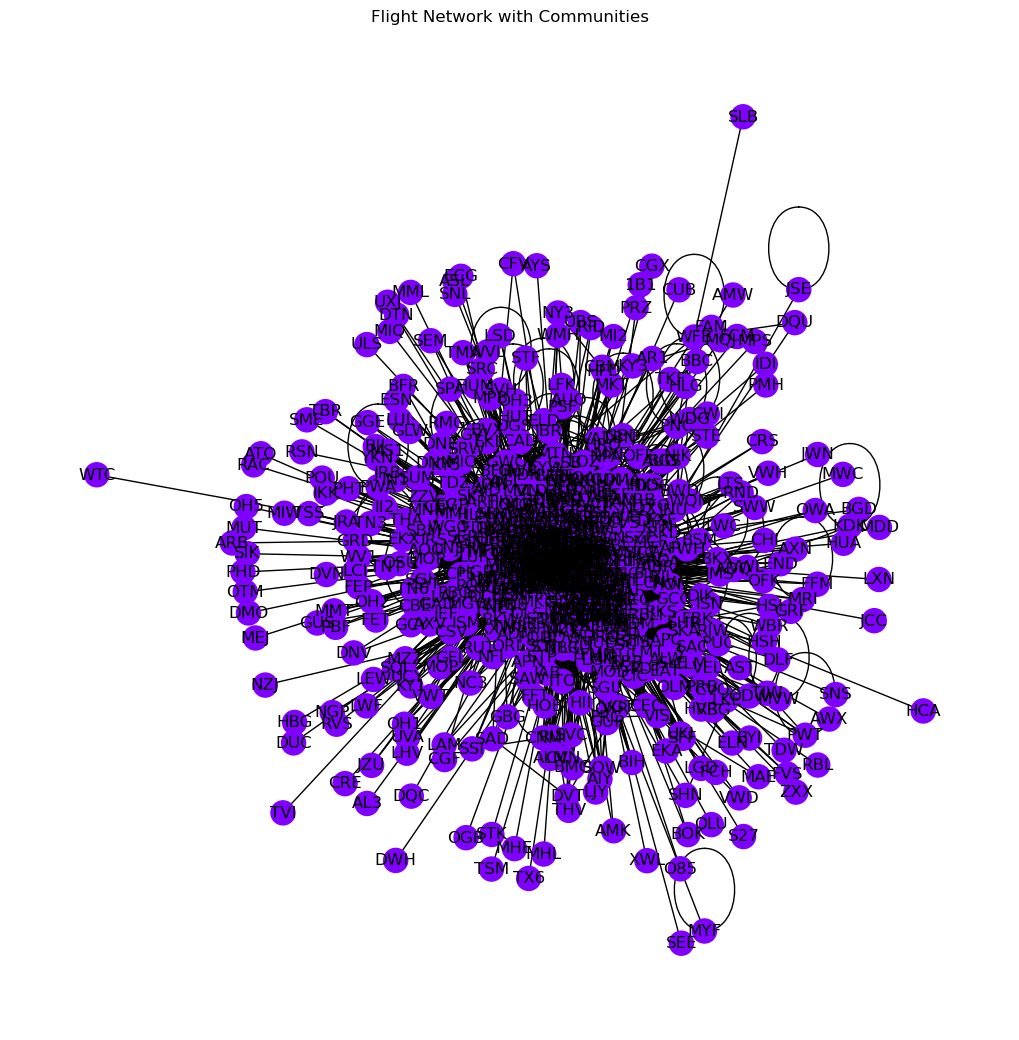

Cities MHK and EUG are in the same community.


In [ ]:
def find_communities(flight_network, c1, c2):

    G = nx.Graph(flight_network)

    # Find connected communities
    communities = list(nx.connected_components(G))

    city_to_community = {}
    for community_id, community in enumerate(communities):
        for city in community:
            city_to_community[city] = community_id

    # Check if c1 and c2 belong to the same community
    if city_to_community.get(c1) == city_to_community.get(c2):
        same_community = True
    else:
        same_community = False

    print(f'Total number of communities: {len(communities)}')
    for community_id, community in enumerate(communities):
        print(f'Community {community_id + 1}: {sorted(community)}')

    # Visualize the graph with communities
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G) 
    colors = [city_to_community[node] for node in G.nodes()]

    nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
    plt.title('Flight Network with Communities')
    plt.show()

    return same_community, len(communities), communities

### Call the functions
c1 = 'MHK'
c2 = 'EUG'

same_community, total_communities, communities = find_communities(flight_network, c1, c2)
if same_community:  
    print(f'Cities {c1} and {c2} are in the same community.')
else:
    print(f'Cities {c1} and {c2} are not parts of the same community.')

As a result, we can observe that the above implemented code indicates presences of only a single community in the flight_network. The two selected airports MHK and EUG both fall into it.


#### Edge Betweenness Centrality
Represents the number of shortest paths that pass through an edge in a network.

#### Louvain Algorithm
It is a popular method for community detection in large networks. It works by optimizing the modularity of the network—a measure that quantifies the strength of division of a network into communities. The algorithm iteratively refines communities to maximize modularity.

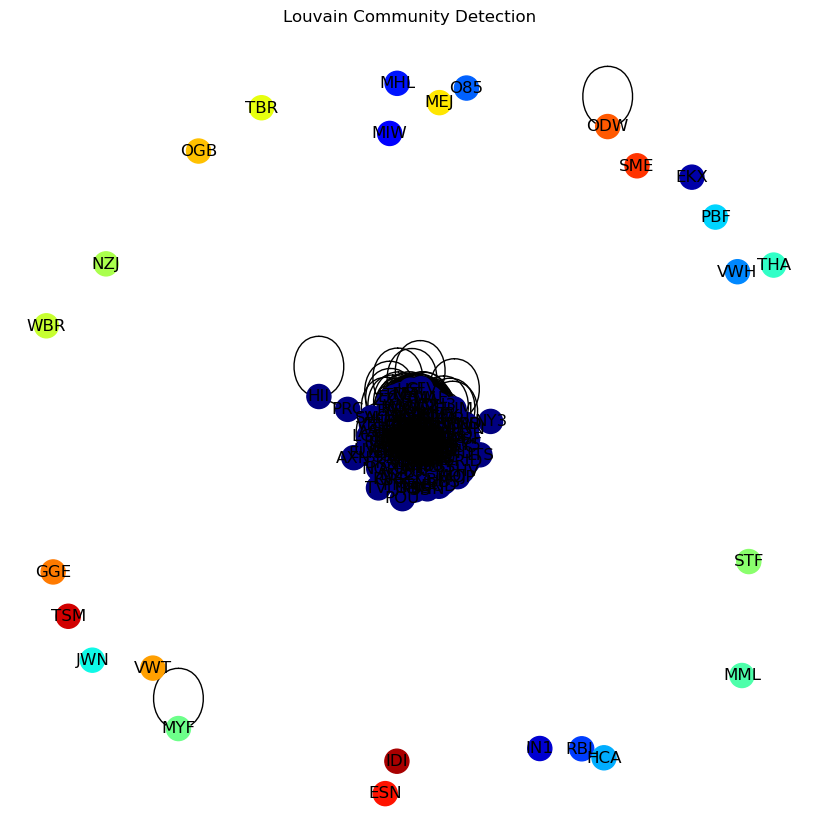

Number of communities: 27
Communities: defaultdict(<class 'list'>, {'BKW': ['BFF', 'CLL', 'BUF', 'BTM', 'DMA', 'SLE', 'SRW', 'HSI', 'ILM', 'AOO', 'STC', 'HUF', 'APN', 'TYR', 'ESF', 'SBA', 'YNG', 'NZC', 'ORD', 'FOD', 'MEI', 'SVN', 'NGP', 'LTS', 'AUG', 'UBS', 'SFO', 'MDT', 'LOZ', 'OGD', 'LGD', 'RVS', 'GBD', 'JLN', 'MKL', 'LMT', 'MKG', 'ALM', 'TYS', 'DRO', 'ACT', 'SVC', 'RST', 'HFD', 'FLO', 'CFV', 'ISN', 'WRB', 'RDU', 'EFD', 'MOP', 'MHK', 'EIL', 'HLN', 'PBG', 'AZO', 'ERI', 'SAV', 'UCA', 'CRW', 'BOS', 'ANC', 'BIL', 'ATL', 'CSG', 'PRC', 'END', 'TIK', 'CID', 'SPS', 'SBM', 'SJC', 'BAD', 'MOT', 'SBY', 'ART', 'SHV', 'ROW', 'MPB', 'POU', 'BKX', 'PIB', 'TMA', 'AUS', 'ACV', 'AGC', 'GSB', 'OAK', 'HUM', 'WGO', 'MLU', 'BZN', 'PMH', 'ELP', 'PAM', 'BFM', 'DYS', 'EGP', 'ECG', 'SAN', 'FSM', 'CHO', 'RFD', 'TPA', 'ALW', 'PDX', 'GCC', 'LCH', 'IMT', 'GCK', 'HKS', 'BRD', 'ANB', 'TWF', 'AND', 'EAU', 'LNK', 'FMN', 'SKY', 'MMI', 'NZY', 'SCK', 'RKD', 'THV', 'PDT', 'MRI', 'RNO', 'IPL', 'SVH', 'MFR', 'CNW', 'ADS', 

In [ ]:
def calculate_modularity(graph, community_assignment):
    '''
    Calculate the modularity of a given community.

    Inputs:
        graph
        community_assignment: A dictionary where keys are nodes and values are community IDs.
    
    Outputs:
        The modularity score.
    '''
    # Get degree for each node
    degrees = {node: sum(1 for _ in graph.neighbors(node)) for node in graph.nodes()}

    total_weight = sum(degrees.values())
    modularity = 0

    # Group nodes by their community
    communities = defaultdict(list)
    for node, community in community_assignment.items():
        communities[community].append(node)

    # Calculate modularity for each community
    for community_nodes in communities.values():
        internal_weight = 0
        degree_sum = 0
        for node in community_nodes:
            for neighbor in community_nodes:
                if graph.has_edge(node, neighbor):
                    internal_weight += 1 
            degree_sum += degrees[node]

        # Modularity formula: Q = (internal_weight / total_weight) - (degree_sum / (2 * total_weight)) ** 2
        modularity += (internal_weight / total_weight) - (degree_sum / (2 * total_weight)) ** 2

    return modularity

def optimize_communities(graph, community_assignment):
    '''
    Try to optimize community assignments by checking each node's best community.

    Input:
        graph
        community_assignment: Current node-to-community mapping.

    Outputs:
        Updated community assignment.
    '''
    has_changes = True
    while has_changes:
        has_changes = False
        for node in graph.nodes():
            original_community = community_assignment[node]
            best_community = original_community
            best_modularity_gain = 0

            # Test all possible communities a node could join
            for neighbor in graph.neighbors(node):
                neighbor_community = community_assignment[neighbor]

                # Temporarily assign the node to the best community
                community_assignment[node] = neighbor_community
                new_modularity = calculate_modularity(graph, community_assignment)
                modularity_gain = new_modularity

                if modularity_gain > best_modularity_gain:
                    best_community = neighbor_community
                    best_modularity_gain = modularity_gain

            # Assign the node to the best community
            if best_community != original_community:
                community_assignment[node] = best_community
                has_changes = True

    return community_assignment

def louvain_algorithm(graph, city_A, city_B):
    '''
    Implementation of Louvain algorithm for the community detection.
    Inputs:
        graph
        city_A: An airport A
        city_B: An airport B

    Outputs:
        The number of communities.
        The city-to-community mapping.
        Whether cities A and B are in the same community.
    '''
    # Check if the cities exist in the graph
    if city_A not in graph.nodes():
        raise ValueError(f'City {city_A} is not in the graph!')
    if city_B not in graph.nodes():
        raise ValueError(f'City {city_B} is not in the graph!')

    # Start with each node in its own community
    community_assignment = {node: node for node in graph.nodes()}

    while True:

        community_assignment = optimize_communities(graph, community_assignment)
        new_community_count = len(set(community_assignment.values()))
        if new_community_count == len(set(community_assignment.values())):
            break

    # Check if city_A and city_B are in the same community
    are_in_same_community = community_assignment.get(city_A) == community_assignment.get(city_B)

    # Group cities by community
    communities = defaultdict(list)
    for city, community in community_assignment.items():
        communities[community].append(city)

    # Number of communities
    num_communities = len(communities)

    # Visualization of communities
    community_colors = {}
    for idx, community in enumerate(communities.values()):
        color = plt.cm.jet(idx / len(communities))
        for city in community:
            community_colors[city] = color

    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color=[community_colors[node] for node in graph.nodes()])
    plt.title('Community Detection using Louvain Algorithm')
    plt.show()

    return num_communities, communities, are_in_same_community

### Excute Louvain algorithm implementation

def random_node_sampling(graph, num_nodes):
    sampled_nodes = random.sample(list(graph.nodes()), num_nodes) 
    sampled_graph = graph.subgraph(sampled_nodes).copy()
    return sampled_graph

sampled_flight_network = random_node_sampling(flight_network, 300)

num_communities, communities, are_in_same_community = louvain_algorithm(sampled_flight_network, 'MHK', 'EUG')

print(f'Number of communities: {num_communities}')
print('Communities:', communities)
print(f'Are 'MHK' and 'EUG' in the same community? {are_in_same_community}')



Using the Louvain algorithm on a random sample of 300 nodes with their edges preserved, points to a single large community and a few disconnected nodes that form their own unique communities. This is likely due to the disconnection caused by sampling and seems to confirm the result above of a unique community present in this graph.

### Alternative Algorithm: Girvan-Newman Algorithm
The Girvan-Newman algorithm is a widely used alternative for community detection in networks. Unlike the Louvain algorithm, which is modularity-based and hierarchical, Girvan-Newman focuses on edge betweenness centrality, systematically removing edges with high betweenness to reveal community structures.

#### Steps to Implement Girvan-Newman Algorithm based on ChatGPT suggestion:

##### 1. Calculate Edge Betweenness:
Compute the betweenness centrality for all edges in the graph. Betweenness centrality for an edge measures the number of shortest paths that pass through it.
##### 2.Remove Edges:
Identify the edge with the highest betweenness centrality. Remove this edge from the graph.
##### 3.Recalculate:
Recalculate edge betweenness for the updated graph. Repeat steps 2–3 iteratively, progressively disconnecting the graph into smaller components.
##### 4.Stop Condition:
Stop when the desired number of communities is achieved or when removing an edge would separate a desired pair of cities.
##### 5.Output Communities:
Analyze the resulting connected components of the graph as distinct communities.
##### 6.Visualization:
Assign a distinct color to each community and visualize the network.

In [ ]:
def calculate_edge_betweenness_parallel(graph):
    '''
    Compute edge betweenness centrality in parallel.
    Inputs:
        graph
    Outputs:
        Edge betweenness centrality.
    '''
    # Get all edges
    edges = list(graph.edges())

    # Function to compute betweenness for a single edge
    def edge_betweenness(edge):
        node_u, node_v = edge
        # Compute the shortest paths passing through this edge
        shortest_paths = nx.shortest_path(graph)
        betweenness = 0
        for source in shortest_paths:
            for target in shortest_paths[source]:
                if source == target:
                    continue
                path = shortest_paths[source][target]
                if node_u in path and node_v in path:
                    # Check if the edge is on the shortest path
                    edge_index = path.index(node_u)
                    if edge_index + 1 < len(path) and path[edge_index + 1] == node_v:
                        betweenness += 1
        return (edge, betweenness)

    # Compute betweenness centrality in parallel
    results = Parallel(n_jobs=-1)(delayed(edge_betweenness)(edge) for edge in edges)

    # Combine results into a dictionary
    return dict(results)

def girvan_newman_parallel(graph):
    '''
    Implemention of the Girvan-Newman algorithm using parallel edge betweenness centrality in effort to reduce the execution time.

    Outputs:
        List of communities.
    '''
    # Make a copy of the graph
    graph = graph.copy()

    # List to store communities
    communities = []

    # While the graph has edges
    while graph.number_of_edges() > 0:
        # Compute edge betweenness centrality in parallel
        edge_betweenness = calculate_edge_betweenness_parallel(graph)

        # Find the edge with the maximum centrality
        max_edge = max(edge_betweenness, key=edge_betweenness.get)

        # Remove the edge with the highest betweenness
        graph.remove_edge(*max_edge)

        # Check for connected components (communities)
        components = list(nx.connected_components(graph))

        # If the graph has more than one component, store the communities
        if len(components) > 1:
            communities = components

    return communities

### Comparision of implemented algortihms

Efficiency-wise Louvain algorithm seems to be more favourable as its highly-exicient with time complexity O(nlogn), whereas Girvan-Newman is more expensive with a runtime of O(m^2n), where m are edges and n the nodes of the graph. Given the edge recaalculation at everystep in the Girvan-Newman makes it less scalable and hence for larger graphs even less efficient. Louvain on the other hand handles largergraphs quite efficiently.
When it comes to the number of communities and modularity itself, Louvain tends to yield many communities as it optimizesodularity directly. Girvan-Newman identifies fewer and larger communities, that are clear and disjoint, however lack a hierarchical structure. 

## Bonus Question - Connected Components on MapReduce

#### MapReduce 
is ideal for network analysis as it enables parallel processing of large graph datasets, making it scalable and efficient. By breaking tasks into map and reduce steps, it allows for distributed analysis of networks, which is essential for handling large-scale graph problems like connected components.

In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

The function takes the following inputs:
- Flight network
- A starting date
- An end date

The function outputs:
- The number of the connected components during that period
- The size of each connectd componenet
- The airports within the largest connected component identified.

Note: For this task, you should check if there is a flight between two airports during that period. Note: You are not allowed to use pre-existing packages or functions in PySpark; instead, you must implement the algorithm from scratch using the MapReduce paradigm.

Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.

In this question we apply MapReduce a framework for processing large-scale datasets in a distributed and parallel manner. It divides tasks into two main stages: mapping and reduction.

In [ ]:
# We filter the flights based on the desired date
def load_and_filter_data(data, start_date, end_date):

    filtered_flights = []
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    for _, row in data.iterrows(): 
      origin = row['Origin_airport']
      destination = row['Destination_airport']
      fly_date = datetime.strptime(row['Fly_date'], '%Y-%m-%d')
  
    
      if start_date <= fly_date <= end_date:
          filtered_flights.append((origin, destination, fly_date))  

    return filtered_flights

# Create graph of the date filtered flights
def create_graph(flights):

    graph = defaultdict(set)
    for origin, destination, date in flights:
        graph[origin].add(destination)
        graph[destination].add(origin)
    return graph

# Map Step
def map_step(graph, node_component):

    node, component = node_component
    neighbors = graph[node]
    return [(neighbor, component) for neighbor in neighbors]

# Reduce Step
def reduce_step(node1, node2):
    return min(node1, node2)

# Iterative MapReduce Process to Find Connected Components
def connected_components(graph, max_iterations=10):

    # Initialize each node with itself as its own component
    nodes = {node: node for node in graph}  

    for _ in range(max_iterations):
        new_nodes = nodes.copy()

        # For each node we propagate its component ID to neighbors
        for node, component in nodes.items():
            new_components = map_step(graph, (node, component))
            for neighbor, neighbor_component in new_components:

                # Take the minimum component ID for each neighbor
                new_nodes[neighbor] = reduce_step(new_nodes.get(neighbor, neighbor), neighbor_component)
        nodes = new_nodes

    # Group nodes by component ID
    components = defaultdict(list)
    for node, component in nodes.items():
        components[component].append(node)

    return components

# Find the largest component
def analyze_components(components):

    sizes = {component: len(nodes) for component, nodes in components.items()}
    largest_component = max(sizes, key=sizes.get)
    return sizes, largest_component, components[largest_component]


### Execute the functions

start_date = '2008-01-01'
end_date = '2008-12-31'
flight_time_df = data[['Origin_airport','Destination_airport','Fly_date']]


filtered_flights = load_and_filter_data(flight_time_df, start_date, end_date)
graph = create_graph(filtered_flights)
components = connected_components(graph)
sizes, largest_component, airports_in_largest = analyze_components(components)

print('Total Connected Components:', len(sizes))
print('Size of Each Component:', sizes)
print('Largest Component ID:', largest_component)
print('Airports in Largest Component:', airports_in_largest)

Total Connected Components: 2
Size of Each Component: {'ABE': 525, 'PWA': 1}
Largest Component ID: ABE
Airports in Largest Component: ['MHK', 'AMW', 'SEA', 'RDM', 'GEG', 'AZA', 'BIL', 'MFR', 'EUG', 'DLH', 'RNO', 'SLE', 'SLC', 'LMT', 'SFO', 'CEC', 'OKC', 'SAN', 'LAS', 'FSM', 'PDX', 'STS', 'ABQ', 'LAX', 'EKO', 'OAK', 'PUB', 'SFB', 'ERI', 'PHL', 'ACY', 'IND', 'CLE', 'JFK', 'ABE', 'AVP', 'PIT', 'PVD', 'GSO', 'PGV', 'BUF', 'DTW', 'GPT', 'GYY', 'CAE', 'MBS', 'ICT', 'LIT', 'SBN', 'BMG', 'FNT', 'TPA', 'LRD', 'DAY', 'MDT', 'BNA', 'MKE', 'SNA', 'YIP', 'MDW', 'PWM', 'TYS', 'TVC', 'HYS', 'LBL', 'GBD', 'DDC', 'BRL', 'MCI', 'GCK', 'OGG', 'ITO', 'HNL', 'RST', 'APC', 'GUS', 'SUS', 'SJC', 'RFD', 'GRB', 'CMI', 'ANC', 'BWI', 'PHX', 'BFI', 'PUW', 'IAH', 'MEM', 'MOD', 'LBB', 'MCO', 'JAN', 'MSN', 'LNK', 'GRK', 'MOB', 'MLU', 'DFW', 'DAL', 'FWH', 'ACV', 'FAT', 'BOS', 'TUL', 'AUS', 'OMA', 'ACT', 'LGU', 'TUS', 'CWA', 'PIA', 'TOL', 'FOE', 'SPS', 'LCH', 'CRP', 'COS', 'SPI', 'SAT', 'SGF', 'MSY', 'MSP', 'XNA', 'GRR

# Algorithmic Question (AQ)

#### Algorithm Explanation

This algorithm was developed based on Dijkstra's algorithm, a well-known approach for finding the shortest path in a weighted graph. While Dijkstra focuses on minimizing the total cost without constraints, this algorithm extends the concept by adding a restriction on the maximum number of stops (**k**). It efficiently explores the graph using a priority queue, always prioritizing the least costly paths while ensuring that the stop limit is not exceeded.


### Pseudocode

Function: `find_cheapest_price`
**Inputs:**
- `n`: Number of cities
- `flights`: List of flights, where each flight is defined as `(start_city, end_city, cost)`
- `src`: Starting city
- `dst`: Destination city
- `k`: Maximum number of stops

### Algorithm:
1. **Create a graph representation of the flights:**
   - For each flight `(start_city, end_city, cost)`, add `end_city` and `cost` as a neighbor of `start_city`.

2. **Initialize a priority queue** to track the cities to explore:
   - Add an entry with:
     - `current_cost = 0` (initial cost is zero)
     - `current_city = src` (start at the source city)
     - `remaining_stops = k + 1` (allow up to `k+1` stops)
     - `path_so_far = [src]` (initialize path with the source city)

3. **While there are entries in the priority queue:**
   - Remove the entry with the lowest `current_cost`:
     - Let `current_cost` be the total cost to reach `current_city`
     - Let `remaining_stops` be the number of stops still allowed
     - Let `path_so_far` be the path taken so far

   - If `current_city` is the destination:
     - Print `path_so_far`
     - Return `current_cost`

   - If `remaining_stops > 0`:
     - For each neighbor of `current_city`:
       - Compute the `new_cost` to reach the neighbor
       - Update the path by adding the neighbor to `path_so_far`
       - Add an entry to the queue with:
         - `new_cost`
         - `neighbor` as the new current city
         - `remaining_stops - 1`
         - `updated_path`

4. **If no valid path is found after exploring all options:**
   - Print `"No valid path found"`
   - Return `-1`


In [1]:
import heapq
from collections import defaultdict
import math

def find_cheapest_route(n, flights, src, dst, k):
    # Create a graph representation from the list of flights
    graph = defaultdict(list)
    for start, end, cost in flights:
        graph[start].append((end, cost))

    # Initialize a priority queue for path exploration
    # Each element in the queue contains: (current cost, current city, remaining stops, current path)
    priority_queue = [(0, src, k + 1, [src])]

    while priority_queue:
        # Extract the node with the smallest cost from the queue
        current_cost, current_city, remaining_stops, current_path = heapq.heappop(priority_queue)

        # If we reach the destination, print the path and return the cost
        if current_city == dst:
            print("Path found:", current_path)
            return current_cost

        # If there are remaining stops, explore the neighbors
        if remaining_stops > 0:
            for neighbor, price in graph[current_city]:
                new_cost = current_cost + price
                new_path = current_path + [neighbor]

                # Add the neighbor to the queue with the updated cost and reduced stops
                heapq.heappush(priority_queue, (new_cost, neighbor, remaining_stops - 1, new_path))

    # If no valid path is found, print a message and return -1
    print("No path found")
    return -1

In [2]:
#TEST the Algorithm
n = 4  
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]  
src = 0  
dst = 3  
k = 1  
print("Minimum cost:", find_cheapest_route(n, flights, src, dst, k), "\n")
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 1  
print("Minimum cost:", find_cheapest_route(n, flights, src, dst, k), "\n")
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 0  
print("Minimum cost:", find_cheapest_route(n, flights, src, dst, k), "\n")
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]]  
src = 0  
dst = 3  
k = 2  
print("Minimum cost:", find_cheapest_route(n, flights, src, dst, k), "\n")
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]  
src = 0  
dst = 3  
k = 2  
print("Minimum cost:", find_cheapest_route(n, flights, src, dst, k), "\n")


Path found: [0, 1, 3]
Minimum cost: 700 

Path found: [0, 1, 2]
Minimum cost: 200 

Path found: [0, 2]
Minimum cost: 500 

Path found: [0, 1, 3]
Minimum cost: 400 

Path found: [0, 1, 3]
Minimum cost: 400 



### Algorithm Efficiency Analysis

#### Time Complexity

1. **Graph Construction:**
   Building the adjacency list from the list of flights takes:
   - O(E), where E is the number of edges (flights).

2. **Priority Queue Operations:**
   The main operations involve inserting and removing elements from the priority queue:
   - In the worst case, each city is processed up to (k+1) times (once per possible stop level).
   - For each city processed, we iterate over its neighbors. Let d be the maximum out-degree of a node (average number of neighbors per city).
   - Inserting or removing from the priority queue (heap) takes O(log V), where V is the number of cities.

**Total Time Complexity**: O((k+1) * E * log V), simplifying: **O(k * E * log V)**

---

### Space Complexity

1. **Graph Representation:**
   The adjacency list requires:
   - O(E) space to store edges.

2. **Priority Queue:**
   The priority queue can hold up to:
   - O(V * (k+1)) elements in the worst case (each city is added for every stop level).
   - Each element requires O(log V) space for insertion.

3. **Path Tracking:**
   The path array in each queue entry requires:
   - O(V) space per entry in the worst case.

**Total Space Complexity:** **O(V + E + V * (k+1))**

---

#### Efficiency for Large Graphs

As clearly shown by the formula **O(k * E * log V)**, the algorithm's complexity strongly depends on the number of edges **E** and not directly on the number of nodes **V**. In a graph with more nodes but the same number of edges, the complexity increases only slightly. However, the situation is different if the number of edges increases. Consequently:
   - **Sparse Graphs (E ≪ V^2):** Manageable since **E** is proportional to **V**.
   - **Dense Graphs (E ≈ V^2):** More computationally expensive, as **E** dominates both time and space requirements. In this case, the complexity would become: **O(k * V^2 * log V)**

#### Algorithm Optimization

As mentioned earlier, the increase in complexity of this algorithm is not primarily due to the nodes but rather the edges. We consider this algorithm to already be efficient; however, a possible optimization could involve a prior pruning of the graph. For instance, edges that are clearly too expensive to contribute to an optimal solution could be removed. Specifically, flights with a cost exceeding a predefined threshold based on heuristics (e.g., twice the average cost of the edges) could be ignored.




We asked ChatGPT for a more optimized version of the previously described algorithm to solve this problem.
It indeed provided us with a more direct and optimized alternative for this scenario: the modified Bellman-Ford algorithm, which is ideal for problems with transition limits (such as k+1 flights).

In [3]:
from collections import defaultdict
import math

def find_cheapest_price_ChatGPT(n, flights, src, dst, k):
    # Initialize an array to track the minimum costs to reach each city
    # Set it to infinity for all cities except the starting city
    costs = [math.inf] * n
    costs[src] = 0

    # Perform at most k+1 iterations (k stops mean k+1 flights)
    for i in range(k + 1):
        # Create a copy of the cost array to avoid in-place updates
        next_costs = costs[:]
        for start, end, price in flights:
            # Update the cost if a cheaper path is found
            if costs[start] != math.inf and costs[start] + price < next_costs[end]:
                next_costs[end] = costs[start] + price
        costs = next_costs

    # If the cost to reach the destination is still infinity, it means no valid path exists
    return costs[dst] if costs[dst] != math.inf else -1

#TEST the Algorithm
result = find_cheapest_price_ChatGPT(n, flights, src, dst, k)
print("Minimum cost:", result)


Minimum cost: 400


### Complexity and Correctness: Algorithm Comparison

#### Complexity of the Bellman-Ford-Based Algorithm
- **Time Complexity: O(k * |E|)**

  - **k**: Maximum number of iterations (corresponding to the maximum number of stops).
  - **|E|**: Each edge is examined exactly once per iteration.

- **Space Complexity: O(|V|)**
  - Uses an array of size **|V|** to track the minimum costs.

#### Conclusions:
In conclusion, both algorithms are correct, but in our case, the one provided by ChatGPT based on Bellman-Ford is better, as it offers a simpler and more scalable solution with lower computational complexity.
